# 🚀 Snorkel Intro Tutorial: Data Labeling

This tutorial will guide you through using Snorkel to create a training set for classifying tweets from the Sentiment140 dataset. Our goal is to illustrate the core concepts of Snorkel by building a practical sentiment analysis application from scratch, without any manual labeling.

The task is to train a classifier that can predict whether a tweet has a positive or negative sentiment. We have a large dataset of 1.6 million tweets, which we will treat as unlabeled to simulate a real-world scenario where manual labeling is too slow and expensive.

Instead, we'll use a weak supervision approach by writing Labeling Functions (LFs). These are simple Python functions that act as programmatic, noisy heuristics to assign labels. For example, an LF could label any tweet containing the word "happy" as positive.

The tutorial is divided into four main parts:
1. Loading Data: We'll load the Sentiment140 dataset.
2. Writing Labeling Functions (LFs): We'll write several Python functions using heuristics and keywords to label tweets.
3. Combining LF Outputs with the Label Model: We'll use Snorkel's LabelModel to intelligently combine the noisy outputs from our LFs into high-quality probabilistic labels.
4. Training a Classifier: We'll use these generated labels to train a final machine learning model that can classify any new tweet.

## 1. Loading Data

We'll start by loading the Sentiment140 dataset using the load_dataset function from your utils.py file. This function is designed to handle the specific format of the dataset, including:
- Reading the CSV file, which has no header and uses latin-1 encoding.
- Assigning column names: target, ids, date, flag, user, and text.
- Mapping the target polarity labels from 0 (negative) and 4 (positive) to a binary 0/1 format.
- Splitting the data into training and test sets.

We will treat the training data as completely unlabeled. The test set's true labels will be used only for our final evaluation.

In [1]:
#let's install the necessary libraries specified in your requirements.txt file and import the modules we'll need.
!pip install -r requirements.txt

In [2]:
%matplotlib inline

import os
import utils

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

In [3]:
%matplotlib inline
import os
import pandas as pd
import utils # Import our custom utility functions

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"
pd.set_option("display.max_colwidth", 0)

Load and Prepare the Dataset

In [5]:
# Load the dataset using the provided function
df_train, df_test = utils.load_dataset(csv_path="data/sentiment_analysis.csv")

In [8]:
import re
# Text cleaning function
def clean_text(text):
    text = text.lower() # Lowercase text
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'@[^\s]+', '', text) # Remove usernames
    text = re.sub(r'#([^\s]+)', r'\1', text) # Remove the '#' from hashtags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text

In [9]:
# Apply the cleaning function to our data
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

In [10]:
# We hide the training labels to simulate an unlabeled dataset
df_train['label'] = -1

In [11]:
# The ground truth labels for the test set are stored for evaluation
Y_test = df_test["label"].values

print("Cleaned Training Set Sample:")
display(df_train.head())

Cleaned Training Set Sample:


,text,label
0,ahhh i hope your ok,-1
1,cool i have no tweet apps for my razr 2,-1
2,i know just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u,-1
3,school email wont open and i have geography stuff on there to revise stupid school,-1
4,upper airways problem,-1


In [12]:
# Define constants for the labels
ABSTAIN = -1
NEGATIVE = 0
POSITIVE = 1

## 2. Writing Labeling Functions (LFs)

Labeling Functions (LFs) are the core of the weak supervision approach. They are Python functions that programmatically generate labels. They don't need to be perfect; they can be noisy, have limited coverage, and even conflict with each other.

### Recommended practice for LF development

Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging.
A typical cycle consists of the following steps:

1. Look at examples to generate ideas for LFs
1. Write an initial version of an LF
1. Spot check its performance by looking at its output on data points in the training set (or development set if available)
1. Refine and debug to improve coverage or accuracy as necessary

Our goal for LF development is to create a high quality set of training labels for our unlabeled dataset,
not to label everything or directly create a model for inference using the LFs.
The training labels are used to train a separate discriminative model (in this case, one which just uses the comment text) in order to generalize to new, unseen data points.
Using this model, we can make predictions for data points that our LFs don't cover.

We'll walk through the development of two LFs using basic analysis tools in Snorkel, then provide a full set of LFs that we developed for this tutorial.

a) Keyword LFs

The most straightforward LFs often involve looking for specific words that are strong indicators of sentiment.

In [13]:
from snorkel.labeling import labeling_function

# Expanded keyword lists
positive_keywords = [
    "love", "great", "happy", "excellent", "good", "best", "awesome", "amazing",
    "thanks", "fantastic", "perfect", "beautiful", "yay", "excited", "wonderful"
]
negative_keywords = [
    "hate", "bad", "sad", "terrible", "worst", "awful", "horrible", "sucks",
    "disappointed", "sorry", "miss", "cry", "ugh", "annoying"
]

@labeling_function()
def positive_keyword_lf(x):
    return POSITIVE if any(word in x.text for word in positive_keywords) else ABSTAIN

@labeling_function()
def negative_keyword_lf(x):
    return NEGATIVE if any(word in x.text for word in negative_keywords) else ABSTAIN

b) Pattern-Matching LFs (Regular Expressions)

Tweets are rich with patterns like emoticons that strongly signal sentiment. We can use regular expressions to capture these.

In [14]:
@labeling_function()
def emoticon_positive_lf(x):
    return POSITIVE if re.search(r":\)|:-\)|:d|;-\)|;d|=d|=\)|:p", x.text, re.IGNORECASE) else ABSTAIN

@labeling_function()
def emoticon_negative_lf(x):
    return NEGATIVE if re.search(r":\(|:-\(|:'\(|:'-c|:/", x.text, re.IGNORECASE) else ABSTAIN

c) Heuristic LFs

Let's add a more nuanced LF to handle negation, which is a common challenge in sentiment analysis.

In [15]:
@labeling_function()
def negated_positive_lf(x):
    """Labels as NEGATIVE if it contains a negation before a positive word."""
    return NEGATIVE if re.search(r"(not|n't|never|no)\s(love|great|happy|good|best|awesome)", x.text) else ABSTAIN

# A simple heuristic for potential sarcasm
@labeling_function()
def sarcasm_lf(x):
    """Looks for a positive keyword followed by a negative emoticon."""
    return NEGATIVE if re.search(r"(love|great|happy|awesome).{0,15}:\s?\(", x.text) else ABSTAIN

# Look for words that amplify sentiment
intensity_words = ["so", "very", "really", "extremely"]
@labeling_function()
def intense_positive_lf(x):
    """Looks for an intensity word followed by a positive keyword."""
    return POSITIVE if any(f"{intensifier} {pos_word}" in x.text for intensifier in intensity_words for pos_word in positive_keywords) else ABSTAIN

d) Third-Party Model LFs

Using pre-trained models like TextBlob can provide a powerful signal. We use a preprocessor to add sentiment scores to our data points efficiently.

In [16]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob

@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity_lf(x):
    if x.polarity > 0.4:
        return POSITIVE
    elif x.polarity < -0.4:
        return NEGATIVE
    else:
        return ABSTAIN

e) Applying and Analyzing the LFs

Now, we apply all our LFs to the training data to generate the label matrix.

In [17]:
from snorkel.labeling import PandasLFApplier, LFAnalysis

lfs = [
    positive_keyword_lf,
    negative_keyword_lf,
    emoticon_positive_lf,
    emoticon_negative_lf,
    negated_positive_lf,
    textblob_polarity_lf,
]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_test = applier.apply(df=df_test)

# Analyze the performance of our LFs
lf_analysis_summary = LFAnalysis(L=L_train, lfs=lfs).lf_summary()
display(lf_analysis_summary)

100%|██████████| 320000/320000 [01:15<00:00, 4215.39it/s]


,j,Polarity,Coverage,Overlaps,Conflicts
positive_keyword_lf,0,[1],0.206113,0.123955,0.031029
negative_keyword_lf,1,[0],0.164496,0.067552,0.033145
emoticon_positive_lf,2,[],0.000000,0.000000,0.000000
emoticon_negative_lf,3,[],0.000000,0.000000,0.000000
negated_positive_lf,4,[0],0.002909,0.002909,0.002909
textblob_polarity_lf,5,"[0, 1]",0.231827,0.141596,0.014263


In [18]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
positive_keyword_lf,0,[1],0.206113,0.123955,0.031029
negative_keyword_lf,1,[0],0.164496,0.067552,0.033145
emoticon_positive_lf,2,[],0.000000,0.000000,0.000000
emoticon_negative_lf,3,[],0.000000,0.000000,0.000000
negated_positive_lf,4,[0],0.002909,0.002909,0.002909
textblob_polarity_lf,5,"[0, 1]",0.231827,0.141596,0.014263


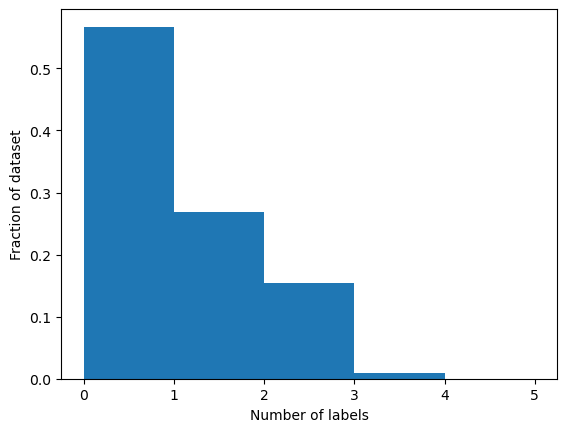

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline


def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

The summary shows statistics like Polarity (the labels an LF outputs), Coverage (the fraction of data it labels), Overlaps, and Conflicts. This helps us understand how our LFs are behaving.

## 3. Combining LF Outputs with the LabelModel

Our LFs are noisy and sometimes disagree. The Snorkel LabelModel is a powerful tool that automatically learns the accuracies and correlations of these LFs without needing any ground-truth labels. It then uses this information to intelligently re-weight and combine their outputs into a single, high-quality set of probabilistic labels.

In [20]:
from snorkel.labeling.model import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [21]:
preds_train

array([ 1, -1,  0, ...,  0,  0,  0])

In [22]:
from snorkel.labeling.model import LabelModel

# Initialize and train the LabelModel
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

# Generate probabilistic labels
probs_train = label_model.predict_proba(L=L_train)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|          | 1/500 [00:00<01:09,  7.20epoch/s]INFO:root:[100 epochs]: TRAIN:[loss=0.002]
INFO:root:[200 epochs]: TRAIN:[loss=0.001]
INFO:root:[300 epochs]: TRAIN:[loss=0.001]
INFO:root:[400 epochs]: TRAIN:[loss=0.001]
100%|██████████| 500/500 [00:00<00:00, 2265.02epoch/s]
INFO:root:Finished Training


In [23]:
majority_acc = majority_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=Y_test, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   61.0%
Label Model Accuracy:     60.5%


Data points that were not labeled by any of our LFs provide no training signal and can hurt performance. We'll filter them out using a built-in Snorkel utility.

In [24]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## 4. Training a Final Classifier

The final step is to use these high-quality probabilistic labels to train a powerful "discriminative" model. This model will learn to generalize beyond our simple heuristics and can classify any new tweet based on its text content.

a) Featurization

First, we must convert our tweet text into numerical feature vectors that a machine learning model can understand. We'll use the "bag of n-grams" approach with CountVectorizer, as defined in your utils.py file.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

# We use a bag-of-words representation with 1-grams and 2-grams
vectorizer = CountVectorizer(ngram_range=(1, 2))

# Featurize the training and test sets using our (modified) utility function
X_train, _ = utils.df_to_features(vectorizer, df_train_filtered, "train")
X_test, _ = utils.df_to_features(vectorizer, df_test, "test")

b) Training the Classifier

We will train a LogisticRegression model from scikit-learn. Since this model requires hard labels (0 or 1) instead of probabilities, we first convert our probabilistic labels into their most likely class predictions using the probs_to_preds utility.

In [26]:
from snorkel.utils import probs_to_preds
from sklearn.linear_model import LogisticRegression

# Convert probabilistic labels to hard integer labels
preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

# Initialize and train the final classifier
sklearn_model = LogisticRegression(solver="liblinear", C=0.1) # Added some regularization
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=0.1, solver='liblinear')

Finally, we evaluate our trained model on the held-out test set to see how well our weak supervision approach worked!

In [27]:
# Score the model on the test set
accuracy = sklearn_model.score(X=X_test, y=Y_test)
print(f"Final Test Accuracy: {accuracy * 100:.1f}%")

Final Test Accuracy: 67.6%
